# SuperStore Sales Prediction

In this notebook, we will predict the sales for the next 7 days using historical data from the last four years.

In [196]:
import warnings
import itertools
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import statsmodels.api as sm
import plotly.io as pio
pio.renderers.default = 'iframe_connected'

In [197]:
df_sales = pd.read_csv('train.csv')
df_sales.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,State,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales
0,1,CA-2017-152156,08/11/2017,11/11/2017,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420.0,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600
1,2,CA-2017-152156,08/11/2017,11/11/2017,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420.0,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400
2,3,CA-2017-138688,12/06/2017,16/06/2017,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,California,90036.0,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200
3,4,US-2016-108966,11/10/2016,18/10/2016,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311.0,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775
4,5,US-2016-108966,11/10/2016,18/10/2016,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311.0,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680


In [198]:
df_sales['Order Date'] = pd.to_datetime(df_sales['Order Date'], dayfirst = True)
df_sales = df_sales.sort_values(by = 'Order Date', ascending = False)
df_sales = df_sales.set_index('Order Date')

In [127]:
df_cat = df_sales.astype({"Category": "category"})
df_sales.loc[df_cat['Category'] == 'Furniture']['Sales']


Order Date
2018-12-30     323.136
2018-12-29      68.460
2018-12-29     258.750
2018-12-29    1207.840
2018-12-29     300.980
                ...   
2015-01-13     545.940
2015-01-11       9.940
2015-01-10      51.940
2015-01-07      76.728
2015-01-06    2573.820
Name: Sales, Length: 2078, dtype: float64

Lets try to plot a time series for each category

In [128]:
cats = df_sales['Category'].unique()

In [129]:
cat = {}
for i in cats:
    cat[i] = df_sales.loc[df_cat['Category'] == i]['Sales'].groupby('Order Date').sum()

In [130]:
office = cat['Office Supplies'].reset_index()
office = office.set_index('Order Date')

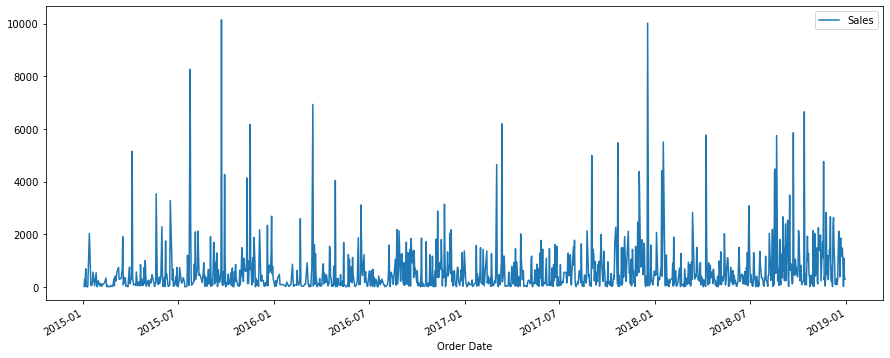

In [131]:
%matplotlib inline
office.plot(figsize = (15,6))
plt.show()

##### But this is not really good to say something. Lets take a look at a smoother graph.

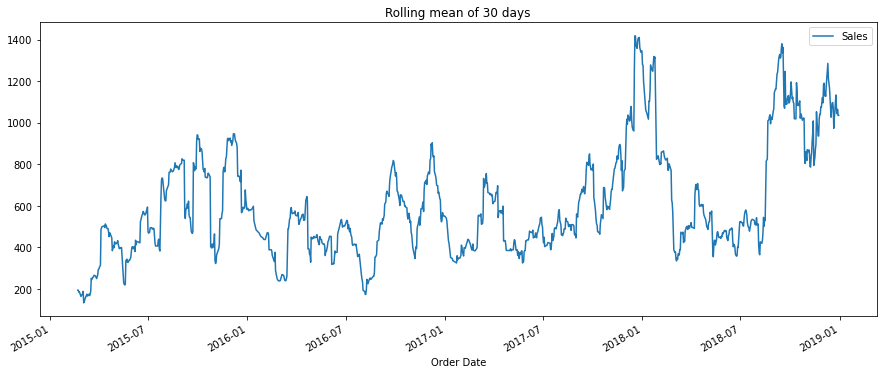

In [132]:
office_mean = office.rolling(window = 30).mean()
office_mean.plot(figsize = (15,6), title = "Rolling mean of 30 days")
plt.show()

Now we can see something about the series. It has a positive trend. But we cannot see if there is any seasonality in the series. For this, we can investigate using the mean per month for the series.

In [133]:
office_month = office['Sales'].resample('MS').mean() #The string MS groups the data by month starting the first day
office_month.head(5)

Order Date
2015-01-01    285.008235
2015-02-01     63.042588
2015-03-01    391.020682
2015-04-01    477.777130
2015-05-01    324.165455
Freq: MS, Name: Sales, dtype: float64

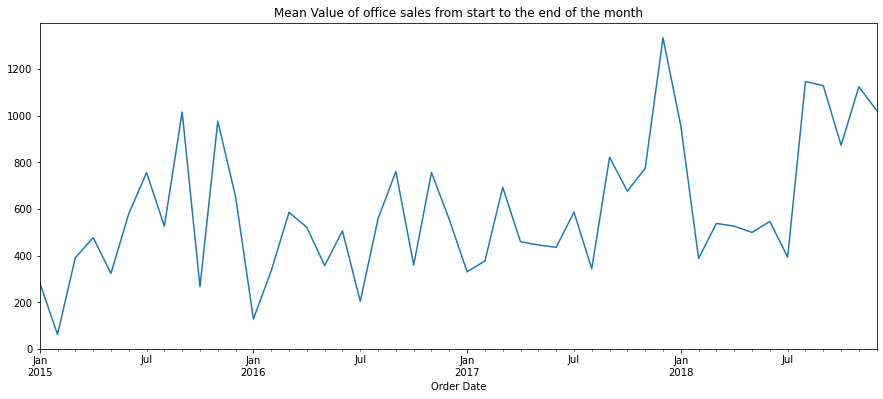

In [134]:
office_month.plot(figsize = (15,6), title = "Mean Value of office sales from start to the end of the month")
plt.show()

We can see the same pattern as before but now seasonality is clearer. It looks like at the beginning of the month, the mean sales are low but increase with time and then again a sudden dorp in monthly mean sales. We can decompose the time series to check for this fact.

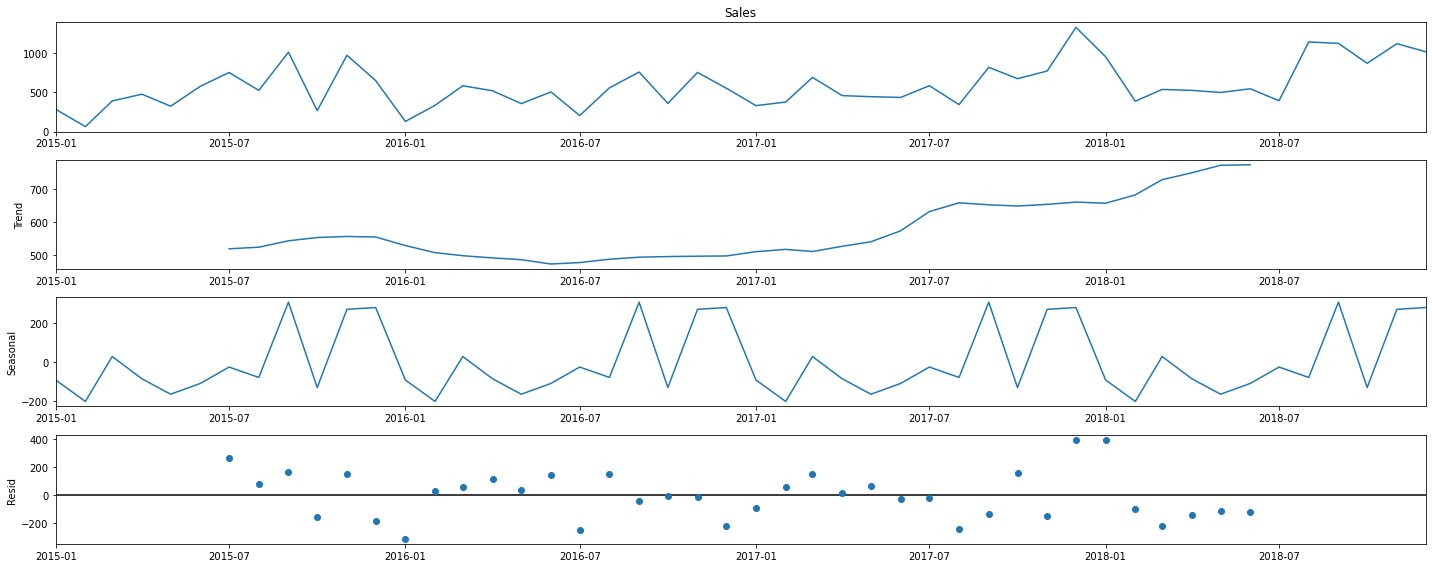

In [135]:
from pylab import rcParams
rcParams['figure.figsize'] = 20, 8
decomposition = sm.tsa.seasonal_decompose(office_month, model='additive')
fig_office = decomposition.plot()
plt.show()

The decomposition of the series shows us the seasonality pattern in the Office category. It would be interesting to do it for the other two categories and then add them together to see the total Sales series. Also, this is monthly data and we want to forecast the next seven days of sales so we have to swith our analysis to daily data.

In [136]:
tech = cat['Technology'].reset_index()
tech = tech.set_index('Order Date')
tech_month = tech['Sales'].resample('MS').mean()
tech_month.head(5)

Order Date
2015-01-01     449.041429
2015-02-01     229.787143
2015-03-01    2157.331600
2015-04-01     640.938857
2015-05-01     564.698588
Freq: MS, Name: Sales, dtype: float64

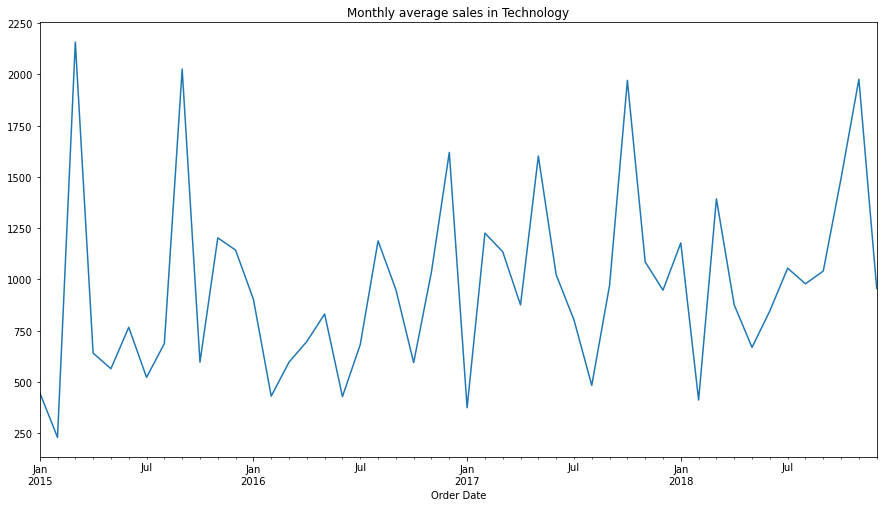

In [137]:
tech_month.plot(figsize = (15,8), title = 'Monthly average sales in Technology')
plt.show()

For this plot, the seasonality is not that obvious. But we can explore it by decomposing the series.

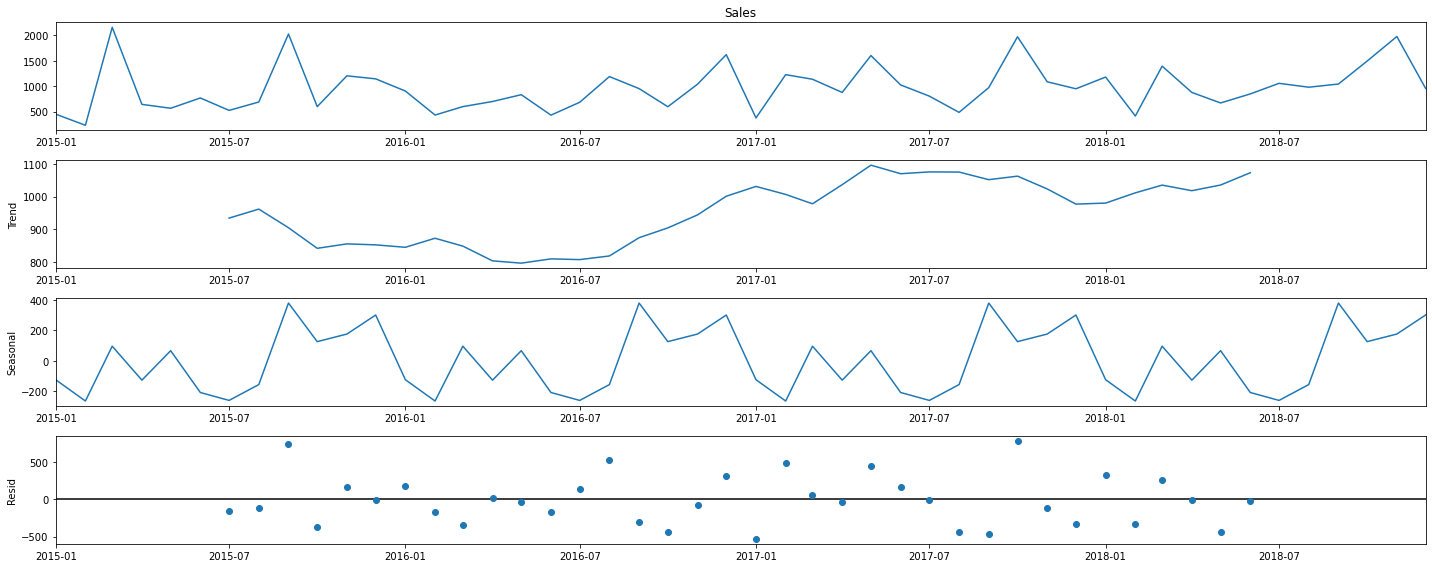

In [138]:
rcParams['figure.figsize'] = 20, 8
decomposition = sm.tsa.seasonal_decompose(tech_month, model='additive')
fig_tech = decomposition.plot()
plt.show()

In [139]:
furniture = cat['Furniture'].reset_index()
furniture = furniture.set_index('Order Date')
furniture_month = furniture['Sales'].resample('MS').mean()
furniture_month.head(5)

Order Date
2015-01-01    518.106417
2015-02-01    367.931600
2015-03-01    837.845176
2015-04-01    567.488357
2015-05-01    432.049187
Freq: MS, Name: Sales, dtype: float64

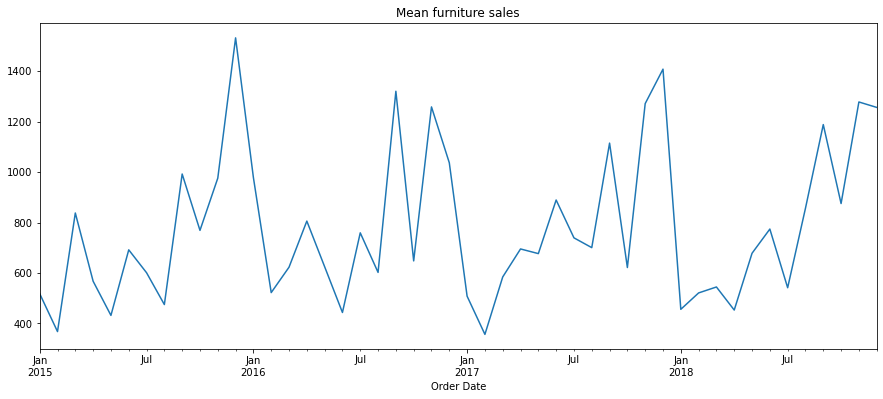

In [140]:
furniture_month.plot(figsize = (15,6), title = 'Mean furniture sales')
plt.show()

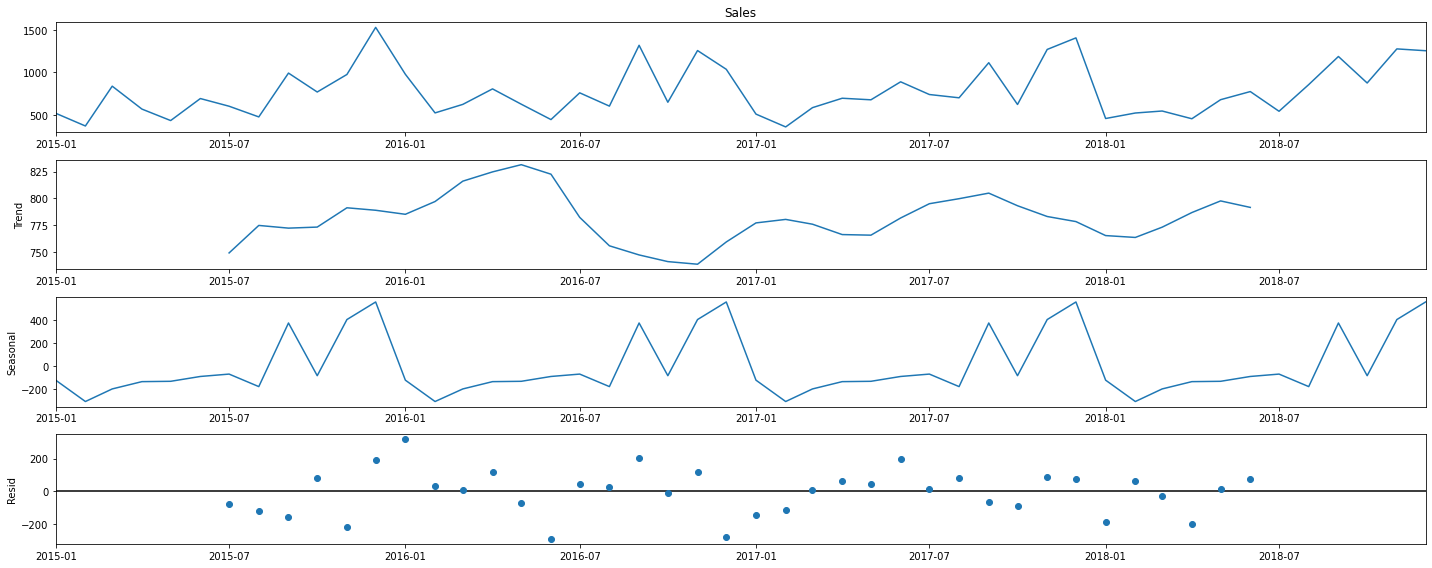

In [141]:
rcParams['figure.figsize'] = 20, 8
decomposition = sm.tsa.seasonal_decompose(furniture_month, model='additive')
fig_furniture = decomposition.plot()
plt.show()

The seasonality for furniture sales is also present. If we plot the ACF we expect to see a high correlation every 12 months. Now  that we now this, we can explore the monthly sales for the total. 

In [142]:
monthly_sales = df_sales.groupby('Order Date').sum()
monthly_sales = monthly_sales['Sales'].resample('MS').mean()

In [144]:
monthly_sales.describe()

count      48.000000
mean     1775.061941
std       812.454746
min       225.994600
25%      1124.826076
50%      1539.262281
75%      2443.701486
max      3931.271833
Name: Sales, dtype: float64

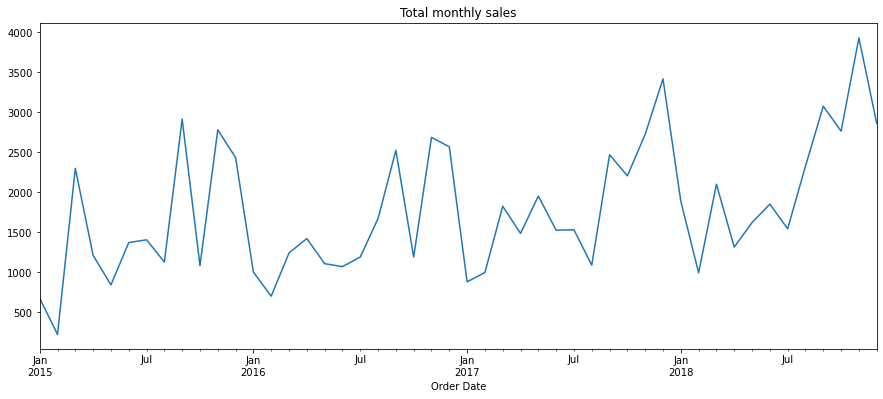

In [146]:
monthly_sales.plot(figsize = (15,6), title = 'Total monthly sales')
plt.show()


The total monthly series shows a positive trend and a seasonality pattern. At the beginning of each year the sales are lower than at the end. It is hard from the graph to tell whether the series are stationary or not. But I suspect it is but we need to add a seasonal term to the ARIMA model, i.e a SARIMA model. Lets take a look at the autocorrelation and partial autocorrelation functions (ACF and PACF). 

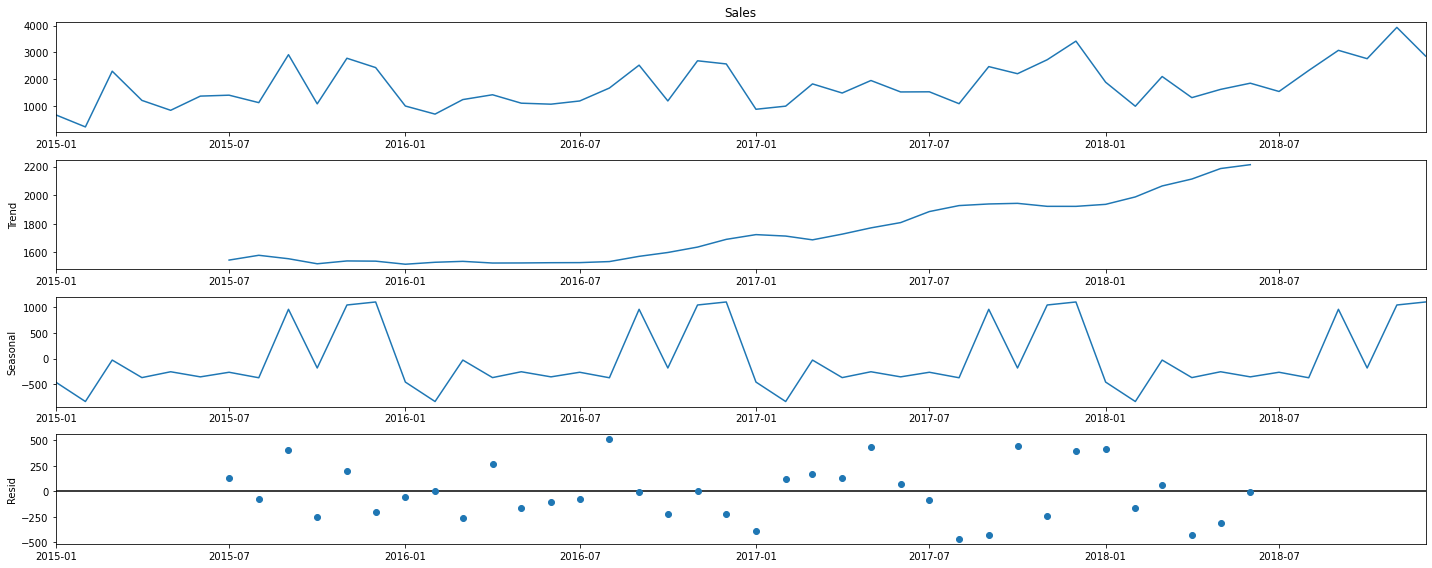

In [ ]:
rcParams['figure.figsize'] = 20, 8
decomposition = sm.tsa.seasonal_decompose(monthly_sales, model='additive')
fig_furniture = decomposition.plot()
plt.show()

## Autocorrelation and Partial Autocorrelation Functions.

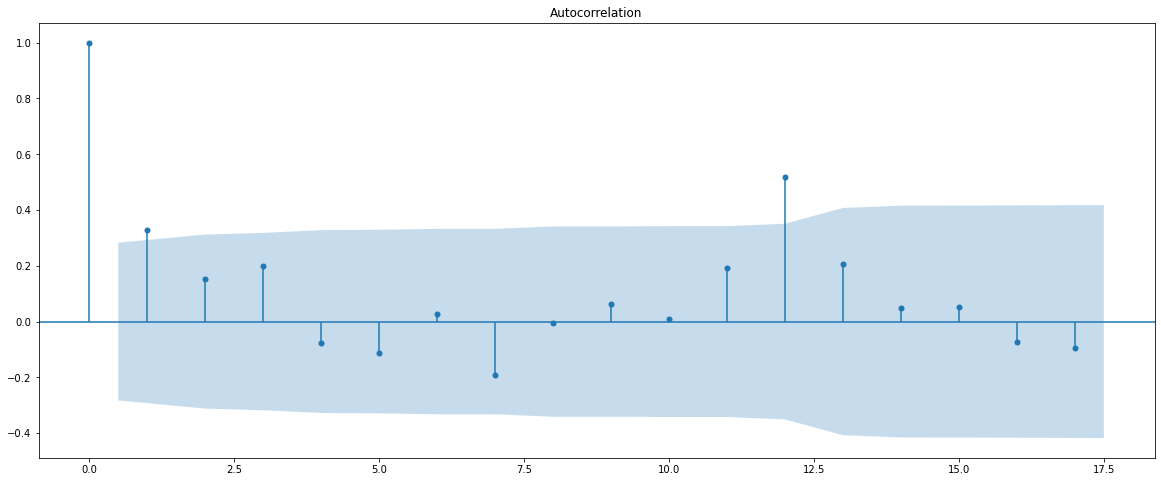

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(monthly_sales)
plt.show()


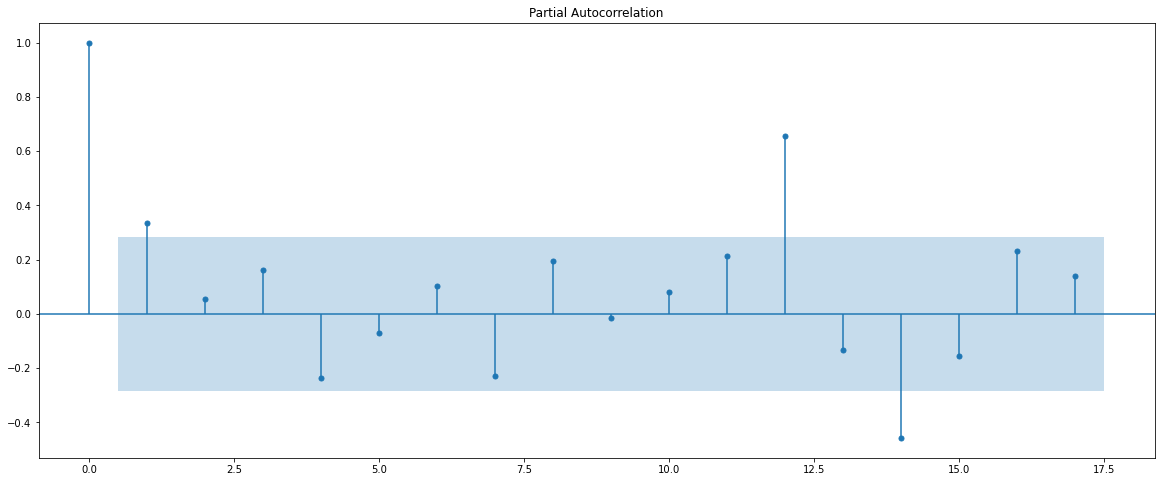

In [ ]:
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(monthly_sales)
plt.show()

For this time series, it seems that the best model to fit is a SARIMA(p,d,q)x(P,D,Q,S) where p, d and q are the non-seasonal orders and P, D, Q and S are the seasonal orders with S being the seasonal period. The ACF shows us the autocorrelation function after 18 lags. Lag 1 is highly correlated with the present value. It is possible to see the seasonality correlation at lag 12. This indicates that the Autoregressive (AR) part of the SARIMA would be at lag 1. The seasonality (S) is at lag 12 and the following lags are not highly correlated with the present value. We can start thinking about possible candidates of our monthly sales model according to these visualizations. The PACF shows the same pattern as the ACF. So the candidate model that might fit the data would be a SARIMA(1,0,1)x(1,0,1,12). It is worth mentioning that the series look stationary as the ACF and PACF are stable after lag 1. But we would like to test for unit roots anyway.

## Tests for unit roots and stationarity

To test these findings we can use a unit-root test and stationarity test. The null hypothesis of the unit-root test is whether the series contains a unit root, in which case then the series is non-stationary. The most used test is the augmented Dickey-Fuller test. Another test that we can look at is the Kwiatkowski-Phillips-Schmidt-Shin test. The difference between the ADF and KPSS test is the null hypothesis. KPSS null hypothesis is that the series has a stationary mean or it is stationary around a deterministic trend.

In [ ]:
warnings.filterwarnings("ignore")


from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
ADFresults_total = adfuller(monthly_sales)
KPSSresults_total = kpss(monthly_sales)
print('ADF Statistic: %f' % ADFresults_total[0])
print('p-value: %f' % ADFresults_total[1])
print('Critical Values:')
for key, value in ADFresults_total[4].items():
	print('\t%s: %.3f' % (key, value))

print('KPSS Statistic: %f' % KPSSresults_total[0])
print('p-value: %f' % KPSSresults_total[1])
print('Critical Values:')
for key, value in KPSSresults_total[3].items():
	print('\t%s: %.3f' % (key, value))


ADF Statistic: -4.693579
p-value: 0.000087
Critical Values:
	1%: -3.578
	5%: -2.925
	10%: -2.601
KPSS Statistic: 0.583648
p-value: 0.024123
Critical Values:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739


We reject the null hypothesis that the series has contains a unit root. But the KPSS tests suggests that the series is not stationary. This might be due to the seasonality.

## Fitting a SARIMA(p,d,q)x(P,D,Q,S) Model

Now that we have a possible candidate for a SARIMA we can investigate some others close to it and compare them by the information criteria. 

In [ ]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [ ]:
warnings.filterwarnings("ignore") # specify to ignore warning messages

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(monthly_sales,
                                            order=param,
                                            seasonal_order=param_seasonal)

            results = mod.fit()

            print('ARIMA{}x{} - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12) - AIC:865.406970871108
ARIMA(0, 0, 0)x(0, 0, 1, 12) - AIC:834.2505496118085
ARIMA(0, 0, 0)x(0, 1, 0, 12) - AIC:559.0623115537194
ARIMA(0, 0, 0)x(0, 1, 1, 12) - AIC:560.0860188356922
ARIMA(0, 0, 0)x(1, 0, 0, 12) - AIC:777.4938815233965
ARIMA(0, 0, 0)x(1, 0, 1, 12) - AIC:778.4635012019237
ARIMA(0, 0, 0)x(1, 1, 0, 12) - AIC:559.7311718765898
ARIMA(0, 0, 0)x(1, 1, 1, 12) - AIC:561.5324271290634
ARIMA(0, 0, 1)x(0, 0, 0, 12) - AIC:833.6439133633221
ARIMA(0, 0, 1)x(0, 0, 1, 12) - AIC:808.675167514728
ARIMA(0, 0, 1)x(0, 1, 0, 12) - AIC:560.4099697092666
ARIMA(0, 0, 1)x(0, 1, 1, 12) - AIC:560.8127485995597
ARIMA(0, 0, 1)x(1, 0, 0, 12) - AIC:774.4179423061289
ARIMA(0, 0, 1)x(1, 0, 1, 12) - AIC:773.3982255846037
ARIMA(0, 0, 1)x(1, 1, 0, 12) - AIC:560.3400277258764
ARIMA(0, 0, 1)x(1, 1, 1, 12) - AIC:562.256584732711
ARIMA(0, 1, 0)x(0, 0, 0, 12) - AIC:776.2398599042825
ARIMA(0, 1, 0)x(0, 0, 1, 12) - AIC:767.9343709259704
ARIMA(0, 1, 0)x(0, 1, 0, 12) - AIC:562.8023772374

The best models according to the AIC are: 
- `ARIMA(0, 1, 1)x(0, 1, 1, 12) - AIC:535.6838131841038`
- `ARIMA(0, 1, 1)x(1, 1, 0, 12) - AIC:538.1868281407704`
- `ARIMA(0, 1, 1)x(1, 1, 1, 12) - AIC:537.5373884904915`
- `ARIMA(1, 1, 1)x(0, 1, 1, 12) - AIC:537.6833251686304`

We can compare them by BIC which is another information criteria. 

In [ ]:
par_nons = [[0,1,1],[1,1,1]]
par_s = [[0,1,1,12],[1,1,1,12], [1,1,0,12]]
for par in par_nons:
    for pars in par_s:
        try:
            mod = sm.tsa.statespace.SARIMAX(monthly_sales,
                                            order=par,
                                            seasonal_order=pars)
            results = mod.fit()

            print('ARIMA{}x{} - AIC:{}'.format(par, pars, results.bic))
        except:
            continue
                                            


ARIMA[0, 1, 1]x[0, 1, 1, 12] - AIC:540.349857368572
ARIMA[0, 1, 1]x[1, 1, 1, 12] - AIC:543.7587807364491
ARIMA[0, 1, 1]x[1, 1, 0, 12] - AIC:542.8528723252386
ARIMA[1, 1, 1]x[0, 1, 1, 12] - AIC:543.904717414588
ARIMA[1, 1, 1]x[1, 1, 1, 12] - AIC:547.3141681357325
ARIMA[1, 1, 1]x[1, 1, 0, 12] - AIC:546.3097376237387


The best model according to the BIC and AIC is `ARIMA[0, 1, 1]x[0, 1, 1, 12] - AIC:540.349857368572`. Now we are ready to do some residual analyses with this model and then proceed to the forecasting part.

#### Model Estimation and Residual Analysis

In [ ]:
mod = sm.tsa.statespace.SARIMAX(monthly_sales,
                                order=(0, 1, 1),
                                seasonal_order=(0, 1, 1, 12),)

results = mod.fit()

print(results.summary())

                                     SARIMAX Results                                      
Dep. Variable:                              Sales   No. Observations:                   48
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -264.842
Date:                            Thu, 30 Sep 2021   AIC                            535.684
Time:                                    16:53:03   BIC                            540.350
Sample:                                01-01-2015   HQIC                           537.295
                                     - 12-01-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.8967      0.152     -5.913      0.000      -1.194      -0.599
ma.S.L12      -0.9932     24.016   

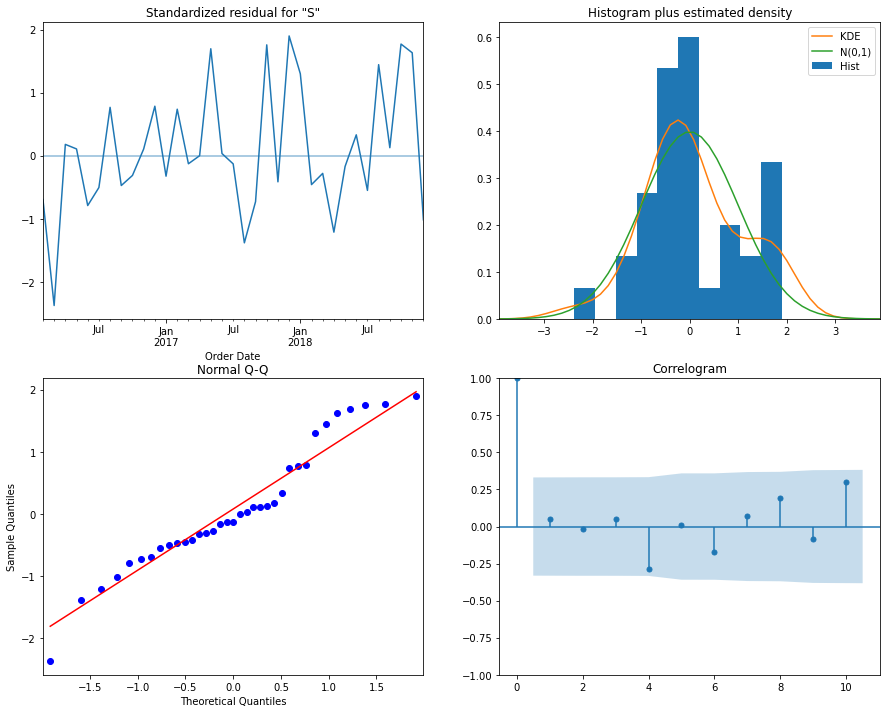

In [ ]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()

According to the `summary` the `coef` of the MA(1) is signficantly different from zero. However, for the MA(1)s is not significantly different from zero. By removing this coefficient, the AIC and BIC increase which tell us that the model is not fitting the data very well.  

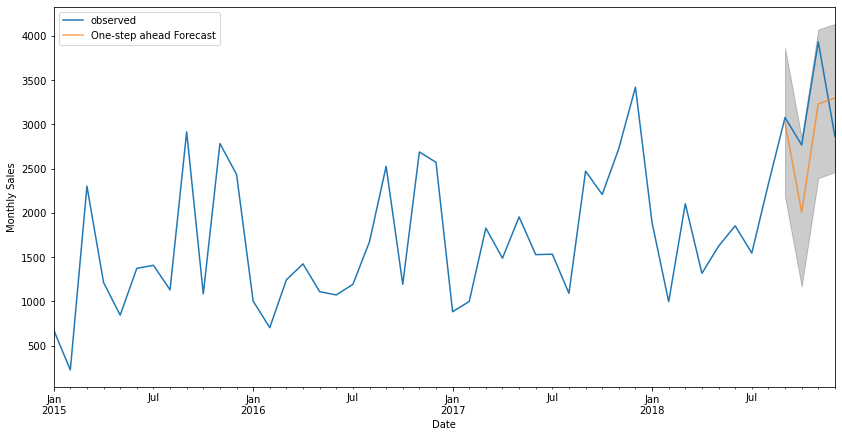

In [ ]:
pred = results.get_prediction(start=pd.to_datetime('2018-09-01'), dynamic=False)
pred_ci = pred.conf_int()
ax = monthly_sales['2014':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Monthly Sales')
plt.legend()
plt.show()

In [ ]:
monthly_forecasted = pred.predicted_mean
monthly_truth = monthly_sales['2018-09-01':]
mse = ((monthly_forecasted - monthly_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 314036.3


In [ ]:
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of our forecasts is 560.39


The model predicts with a RMSE of 560.36. It is not bad but it could be better. We could try to predict using the Facebook tool "Prophet" but lets move on with daily sales to see if we can predict correctly the next seven days of sales.

## Daily Sales

In [232]:
daily = df_sales.groupby('Order Date').sum()
daily = daily['Sales'].reset_index()
daily = daily.set_index('Order Date')
daily_2018 = daily['2018-09':]
daily_2018.index


DatetimeIndex(['2018-09-01', '2018-09-02', '2018-09-03', '2018-09-04',
               '2018-09-05', '2018-09-07', '2018-09-08', '2018-09-09',
               '2018-09-10', '2018-09-11',
               ...
               '2018-12-21', '2018-12-22', '2018-12-23', '2018-12-24',
               '2018-12-25', '2018-12-26', '2018-12-27', '2018-12-28',
               '2018-12-29', '2018-12-30'],
              dtype='datetime64[ns]', name='Order Date', length=115, freq=None)

There are not daily orders. We have to impute zeros for the dates missing in order to fit a model.  lqndw 

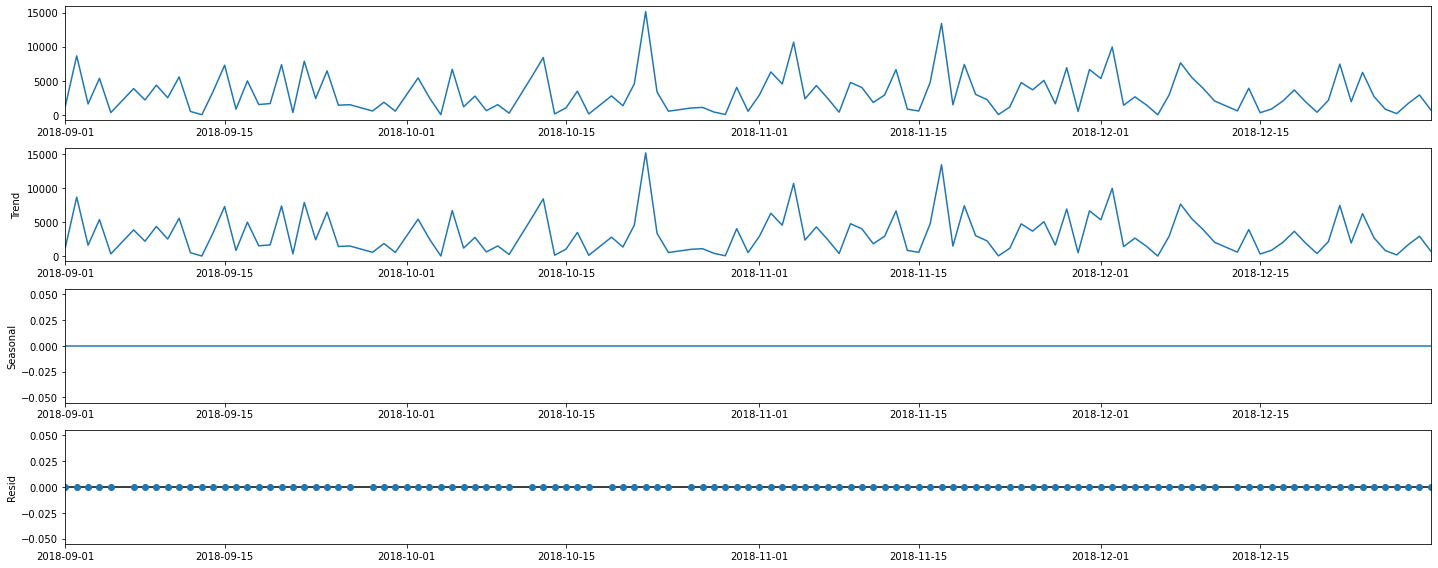

In [233]:
rcParams['figure.figsize'] = 20, 8
decomposition = sm.tsa.seasonal_decompose(daily_2018, model='additive', freq = 1)
fig_daily = decomposition.plot()
plt.show()

In [207]:
daily_2018

Order Date
2018-09-01    1261.8100
2018-09-02    8652.3340
2018-09-03    1595.8490
2018-09-04    5360.2020
2018-09-05     327.0440
                ...    
2018-12-26     814.5940
2018-12-27     177.6360
2018-12-28    1657.3508
2018-12-29    2915.5340
2018-12-30     713.7900
Name: Sales, Length: 115, dtype: float64

In [229]:
daily

,Sales
Order Date,
2015-01-03,16.4480
2015-01-04,288.0600
2015-01-05,19.5360
2015-01-06,4407.1000
2015-01-07,87.1580
...,...
2018-12-26,814.5940
2018-12-27,177.6360
2018-12-28,1657.3508


In [230]:
daily['2018':]

,Sales
Order Date,
2018-01-01,1481.8280
2018-01-02,2079.5540
2018-01-03,2070.2720
2018-01-06,33.7400
2018-01-07,3395.5900
...,...
2018-12-26,814.5940
2018-12-27,177.6360
2018-12-28,1657.3508


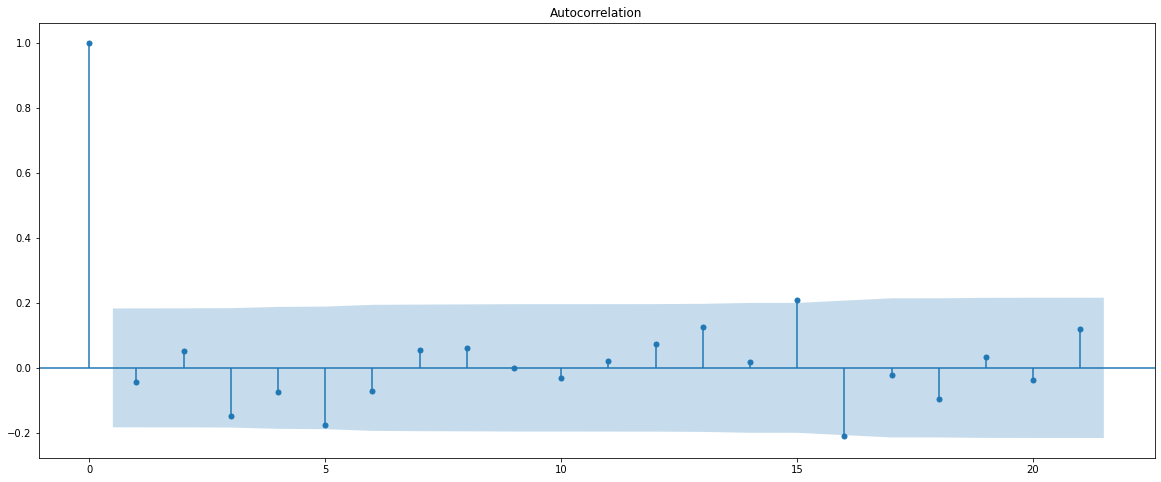

In [235]:
plot_acf(daily_2018)
plt.show()

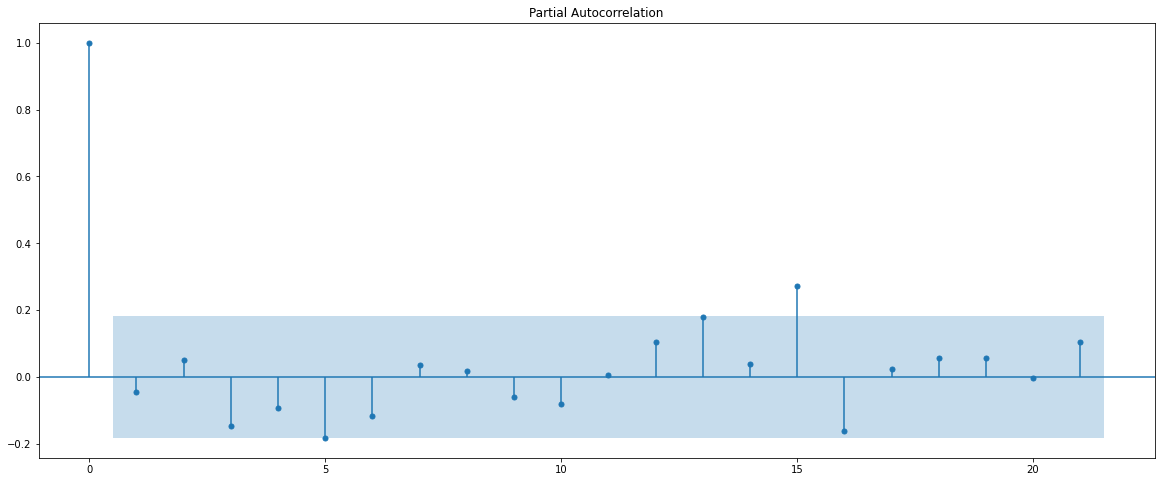

In [237]:
plot_pacf(daily_2018)
plt.show()

In [240]:
adfuller(daily_2018)
kpss(daily_2018)

(0.12139498497952514,
 0.1,
 13,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})